In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
import json
import os
import sys
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from random import choice
from time import time
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [17]:
df = pd.read_csv("datos_fotmob_completo.csv")
# Cambiamos los nombres de algunas variables, dropeamos los valores vacios y ordenamos por fecha
# La fecha va de la más antigua a la más nueva
df.rename(columns={'homeTeam_score': 'score_home',
          "awayTeam_score": "score_away"}, inplace=True)
df.rename(columns={'homeTeam': 'team_home',
          "awayTeam": "team_away"}, inplace=True)
df = df.sort_values(by="date", ignore_index=True)
df = df.drop(["discipline_away", "discipline_home", "duels_home", "duels_away",
             "defense_home", "defense_away", "shots_home", "shots_away"], axis=1)
# Este dropeo es por mientras
df = df.drop(["accurate_passes_home", "accurate_passes_away", "long_balls_accurate_home", "long_balls_accurate_away", "accurate_crosses_home", "accurate_crosses_away",
              "tackles_succeeded_home", "tackles_succeeded_away", "ground_duels_won_home", "ground_duels_won_away", "aerials_won_home", "aerials_won_away",
              "dribbles_succeeded_home", "dribbles_succeeded_away"], axis=1)
# Filtros de liga y equipo
df = df.drop(["leagueId", "parentLeagueId", "leagueName",
             "homeIdTeam", "awayIdTeam"], axis=1)
# Este dropeo hay que conversarlo
df.head()

,id,date,team_home,team_away,score_home,score_away,BallPossesion_home,BallPossesion_away,ShotsOnTarget_home,ShotsOnTarget_away,...,expected_goals_home,expected_goals_away,expected_goals_open_play_home,expected_goals_open_play_away,expected_goals_set_play_home,expected_goals_set_play_away,expected_goals_non_penalty_home,expected_goals_non_penalty_away,expected_goals_on_target_home,expected_goals_on_target_away
0,1474723,2014-01-01,Swansea City,Manchester City,2,3,51.0,49.0,8.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1475995,2014-01-01,Scunthorpe United,Rochdale,3,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1474676,2014-01-01,Arsenal,Cardiff City,2,0,69.0,31.0,15.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1474680,2014-01-01,Crystal Palace,Norwich City,1,1,45.0,55.0,7.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1474689,2014-01-01,Fulham,West Ham United,2,1,69.0,31.0,13.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475283 entries, 0 to 475282
Data columns (total 66 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   id                               475283 non-null  int64  
 1   date                             475283 non-null  object 
 2   team_home                        475283 non-null  object 
 3   team_away                        475283 non-null  object 
 4   score_home                       475283 non-null  int64  
 5   score_away                       475283 non-null  int64  
 6   BallPossesion_home               137910 non-null  float64
 7   BallPossesion_away               137910 non-null  float64
 8   ShotsOnTarget_home               137910 non-null  float64
 9   ShotsOnTarget_away               137910 non-null  float64
 10  ShotsOffTarget_home              137910 non-null  float64
 11  ShotsOffTarget_away              137910 non-null  float64
 12  fo

In [19]:
# Estadisticas simples, ver si jugar en casa afecta
home_win = 0
away_win = 0
draw = 0

total = len(df)
home_win_percentage = sum(df["score_home"] > df["score_away"])/total
away_win_percentage = sum(df["score_home"] < df["score_away"])/total
draw_perentage = sum(df["score_home"] == df["score_away"])/total

In [20]:
print(home_win_percentage)
print(away_win_percentage)
print(draw_perentage)

0.4343096639265448
0.2995646804114601
0.2661256556619951


In [21]:
def get_features(data):
    return pd.DataFrame(data[4:54]).T


def search_features(i, df, last_games):
    team_home = df.iloc[i]["team_home"]
    team_away = df.iloc[i]["team_away"]
    # Para hacer la busqueda más eficiente, solo buscamos en los partidos que estos equipos juegan
    df_match_home1 = df[df["team_home"] == team_home]
    df_match_home2 = df[df["team_away"] == team_home]
    df_match_away1 = df[df["team_home"] == team_away]
    df_match_away2 = df[df["team_away"] == team_away]

    merged_df_home = pd.concat([df_match_home1, df_match_home2])
    merged_df_home.drop_duplicates(inplace=True)
    merged_df_home = merged_df_home.sort_values(by="date", ascending=False)

    merged_df_away = pd.concat([df_match_away1, df_match_away2])
    merged_df_away.drop_duplicates(inplace=True)
    merged_df_away = merged_df_away.sort_values(by="date", ascending=False)

    # El index 0 es el partido, por lo que iteramos desde el 1
    data_home = pd.DataFrame()
    data_away = pd.DataFrame()
    try:
        for j in range(1, last_games+1):
            if team_home == merged_df_home.iloc[j]["team_home"]:
                d = get_features(merged_df_home.iloc[j])
                d["played_home"] = 1
                d["played_away"] = 0
                data_home = pd.concat([data_home, d])
            elif team_home == merged_df_home.iloc[j]["team_away"]:
                d = get_features(merged_df_home.iloc[j])
                d["played_home"] = 0
                d["played_away"] = 1
                data_home = pd.concat([data_home, d])

        for j in range(1, last_games+1):
            if team_away == merged_df_away.iloc[j]["team_home"]:
                d = get_features(merged_df_away.iloc[j])
                d["played_home"] = 1
                d["played_away"] = 0

                data_away = pd.concat([data_away, d])
            elif team_away == merged_df_away .iloc[j]["team_away"]:
                d = get_features(merged_df_away.iloc[j])
                d["played_home"] = 0
                d["played_away"] = 1
                data_away = pd.concat([data_away, d])

        data = pd.concat([data_home, data_away])

        data = data.reset_index(drop=True)

        data = data.stack().to_frame().T

        # Resultado:
        # W = home_win, D = draw, L = home_lose
        if df.iloc[i]["score_home"] > df.iloc[i]["score_away"]:
            data["Resultado"] = "W"
        elif df.iloc[i]["score_home"] == df.iloc[i]["score_away"]:
            data["Resultado"] = "D"
        elif df.iloc[i]["score_home"] < df.iloc[i]["score_away"]:
            data["Resultado"] = "L"

        # Resultado númerico:
        home_score = df.iloc[i]["score_home"]
        away_score = df.iloc[i]["score_away"]
        # Buscar a cual le queda
        if home_score >= 5 and away_score < 5:
            data["Resultado_Numerico"] = f"{5}>-{away_score}"
        elif home_score < 5 and away_score >= 5:
            data["Resultado_Numerico"] = f"{home_score}-{5}>"
        elif home_score >= 5 and away_score >= 5:
            data["Resultado_Numerico"] = f"{5}>-{5}>"
        else:
            data["Resultado_Numerico"] = f"{home_score}-{away_score}"
        return data
    except:
        return pd.DataFrame()



In [22]:
# Pruebas de dataframe
df_test = df[df["red_cards_away"].notnull()].reset_index(drop=True)
lista_de_testeo= list(df_test.index)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92719 entries, 0 to 92718
Data columns (total 66 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               92719 non-null  int64  
 1   date                             92719 non-null  object 
 2   team_home                        92719 non-null  object 
 3   team_away                        92719 non-null  object 
 4   score_home                       92719 non-null  int64  
 5   score_away                       92719 non-null  int64  
 6   BallPossesion_home               92719 non-null  float64
 7   BallPossesion_away               92719 non-null  float64
 8   ShotsOnTarget_home               92719 non-null  float64
 9   ShotsOnTarget_away               92719 non-null  float64
 10  ShotsOffTarget_home              92719 non-null  float64
 11  ShotsOffTarget_away              92719 non-null  float64
 12  fouls_home        

In [23]:
# Programa lineal
last_games = 15
resultados = []
df_nn = pd.DataFrame()
for i in tqdm(lista_de_testeo):
    info = search_features(i,df_test.head(i+1),last_games)
    resultados.append(info)
df_nn = pd.concat(resultados)

100%|██████████| 92719/92719 [57:39<00:00, 26.80it/s]  


In [74]:
# Programa paralelo (Cuidado que a veces las particiones se quedan sin memoria, error de pickle)

# Last games = Juegos pasados a tener en cuenta
# Num_trabajadores = Trabajadores en paralelo (usar -1 para todos los posibles)
# Se demora un par de minutos
last_games = 15
num_trabajadores = -1
resultados = Parallel(n_jobs=num_trabajadores,verbose=10)(
    delayed(search_features)(i,df_test.head(i+1), last_games) for i in lista_de_testeo)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1797405857950999s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09229493141174316s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09651923179626465s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    1.6s
[Parallel(n_jobs

PicklingError: Could not pickle the task to send it to the workers.

In [24]:
df_nn.to_csv("Dataframe_Auxiliar.csv")

In [18]:
df_nn = pd.read_csv("Dataframe_Auxiliar.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'Dataframe_Auxiliar.csv'

In [25]:
df_nn.head()

0                                                   \
  score_home score_away BallPossesion_home BallPossesion_away   
0          1          2               49.0               51.0   
0          2          2               60.0               40.0   
0          1          1               53.0               47.0   
0          1          1               74.0               26.0   
0          2          3               56.0               44.0   

                                                             \
  ShotsOnTarget_home ShotsOnTarget_away ShotsOffTarget_home   
0                7.0                5.0                10.0   
0                7.0                5.0                12.0   
0                5.0                4.0                 6.0   
0                2.0                3.0                 9.0   
0                6.0                2.0                 9.0   

                                             ...            29                \
  ShotsOffTarget_away fouls_home fouls_away  ... duel_won_home duel_won_away   
0                 5.0        8.0       15.0  ...          52.0          63.0   
0                 2.0       16.0       20.0  ...          55.0          59.0   
0                 7.0       10.0       22.0  ...          48.0          44.0   
0                 6.0        8.0       18.0  ...          61.0          55.0   
0                 2.0        6.0       14.0  ...          44.0          57.0   

                                                                     \
  yellow_cards_home yellow_cards_away red_cards_home red_cards_away   
0               1.0               0.0            0.0            0.0   
0               1.0               0.0            0.0            0.0   
0               2.0               0.0            0.0            0.0   
0               5.0               4.0            0.0            0.0   
0               3.0               4.0            0.0            0.0   

                          Resultado Resultado_Numerico  
  played_home played_away                               
0           1           0         D                1-1  
0           0           1         L               0-5>  
0           1           0         L                1-3  
0           0           1         L                2-3  
0           0           1         W                3-2  

[5 rows x 1562 columns]

In [28]:
df_f = pd.DataFrame()
for i in range(2*last_games):
    parte = df_nn[i].add_suffix(f"_{i}",axis=1)
    df_f = pd.concat([df_f,parte],axis=1)
df_f["Resultado"] = df_nn["Resultado"]
df_f["Resultado_Numerico"] = df_nn["Resultado_Numerico"]



In [29]:
df_f.head()

,score_home_0,score_away_0,BallPossesion_home_0,BallPossesion_away_0,ShotsOnTarget_home_0,ShotsOnTarget_away_0,ShotsOffTarget_home_0,ShotsOffTarget_away_0,fouls_home_0,fouls_away_0,...,duel_won_home_29,duel_won_away_29,yellow_cards_home_29,yellow_cards_away_29,red_cards_home_29,red_cards_away_29,played_home_29,played_away_29,Resultado,Resultado_Numerico
0,1,2,49.0,51.0,7.0,5.0,10.0,5.0,8.0,15.0,...,52.0,63.0,1.0,0.0,0.0,0.0,1,0,D,1-1
0,2,2,60.0,40.0,7.0,5.0,12.0,2.0,16.0,20.0,...,55.0,59.0,1.0,0.0,0.0,0.0,0,1,L,0-5>
0,1,1,53.0,47.0,5.0,4.0,6.0,7.0,10.0,22.0,...,48.0,44.0,2.0,0.0,0.0,0.0,1,0,L,1-3
0,1,1,74.0,26.0,2.0,3.0,9.0,6.0,8.0,18.0,...,61.0,55.0,5.0,4.0,0.0,0.0,0,1,L,2-3
0,2,3,56.0,44.0,6.0,2.0,9.0,2.0,6.0,14.0,...,44.0,57.0,3.0,4.0,0.0,0.0,0,1,W,3-2


In [30]:
df_f.to_csv("Dataframe_Auxiliar.csv")

In [ ]:
df_f = pd.read_csv("Dataframe_Auxiliar.csv")
df_f = df_f.drop("Unnamed: 0", axis=1 )

In [215]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Codificación de etiquetas
label_encoder = LabelEncoder()
# Y = label_encoder.fit_transform(df_f["Resultado"])
Y = label_encoder.fit_transform(df_f["Resultado_Numerico"])

# One-Hot Encoding
onehot_encoder = OneHotEncoder(sparse=False)
Y = onehot_encoder.fit_transform(Y.reshape(-1, 1))
Y = np.asarray(Y).astype('float32')

X = df_f.drop(["Resultado","Resultado_Numerico"],axis =1)
X = np.asarray(X).astype('float32')
scaler = StandardScaler()
X = scaler.fit_transform(X)
# División de datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)


c:\Users\gfuen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [221]:
import tensorflow as tf
from tensorflow.keras import layers, models


drop = 0.0
size_layer = 2 ^ 9
batch_size = 2 ^ 8
epoch = 10
model = model = models.Sequential()
model.add(layers.InputLayer(input_shape=(X_train.shape[1],)))
model.add(layers.Dense(size_layer, activation='relu'),)
model.add(layers.Dense(size_layer, activation='gelu'),)
model.add(layers.Dense(size_layer, activation='gelu'),)
model.add(layers.Dense(size_layer, activation='gelu'),)
model.add(layers.Dense(size_layer, activation='gelu'),)
model.add(layers.Dense(size_layer, activation='relu'),)
model.add(layers.Dense(Y.shape[1], activation='softmax'))
# # Compilamos el modelo
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.1, nesterov=True)
adam = tf.keras.optimizers.Adam(
    learning_rate=0.00001, beta_1=0.9999, beta_2=0.99999)
model.compile(loss='categorical_crossentropy',
              optimizer=adam, metrics=['categorical_accuracy',])

# # Entrenamos el modelo
history = model.fit(X_train, y_train, verbose=1, epochs=epoch, batch_size=batch_size,
                    validation_data=(X_test, y_test))

Epoch 1/10
6022/6022 [==============================] - 12s 2ms/step - loss: 3.5424 - categorical_accuracy: 0.0735 - val_loss: 3.4914 - val_categorical_accuracy: 0.0931
Epoch 2/10
6022/6022 [==============================] - 11s 2ms/step - loss: 3.4017 - categorical_accuracy: 0.0957 - val_loss: 3.3025 - val_categorical_accuracy: 0.0974
Epoch 3/10
6022/6022 [==============================] - 11s 2ms/step - loss: 3.2034 - categorical_accuracy: 0.1080 - val_loss: 3.1387 - val_categorical_accuracy: 0.1166
Epoch 4/10
6022/6022 [==============================] - 11s 2ms/step - loss: 3.0702 - categorical_accuracy: 0.1199 - val_loss: 3.0388 - val_categorical_accuracy: 0.1200
Epoch 5/10
6022/6022 [==============================] - 11s 2ms/step - loss: 3.0055 - categorical_accuracy: 0.1182 - val_loss: 2.9969 - val_categorical_accuracy: 0.1152
Epoch 6/10
6022/6022 [==============================] - 11s 2ms/step - loss: 2.9732 - categorical_accuracy: 0.1159 - val_loss: 2.9728 - val_categorical_acc

471/471 [==============================] - 0s 1ms/step


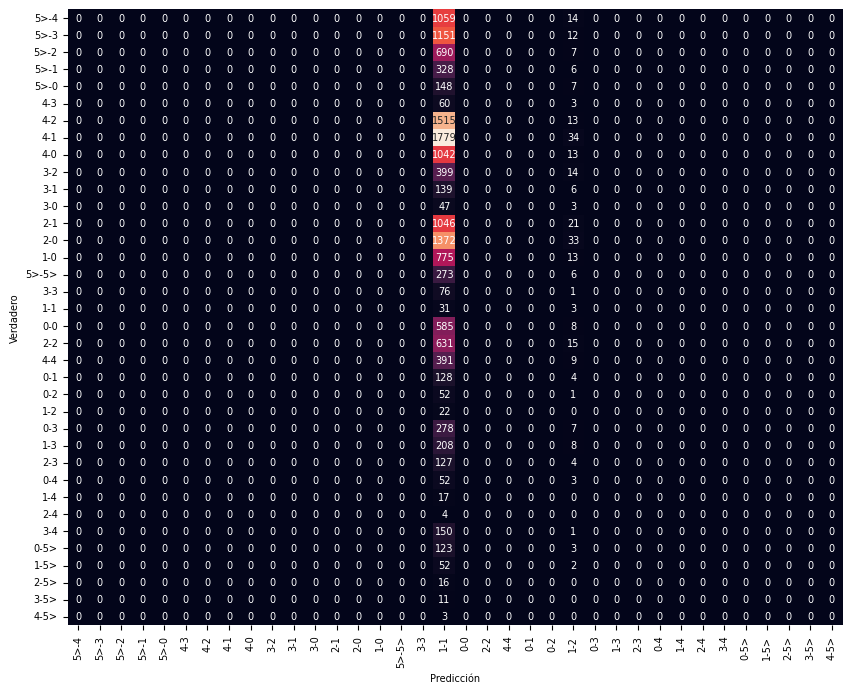

In [305]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sns
from copy import deepcopy
y_prob = model.predict(X_test)
y_test_metrics = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_prob, axis=1) 
y_pred_copy = deepcopy(y_pred)
orden_bonito = np.array([18, 21, 22, 24, 27, 31, 14, 17, 23, 25, 28, 32, 13, 12, 19,
                26, 29, 33, 11, 10, 9, 16, 30, 34, 8, 7, 6, 5, 20, 35, 4, 3, 2, 1, 0, 15])

label = [0 for i in range(len(orden_bonito))]
for i in range(len(label_encoder.classes_)):
    label[orden_bonito[i]] = label_encoder.classes_[i]
    y_pred[y_pred_copy==i] = orden_bonito[i]
    
label = np.array(label)

# Matriz de confusión
conf_matrix = confusion_matrix(y_test_metrics, y_pred)
plt.figure(figsize=(10, 8))

sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False, xticklabels=label,yticklabels=label)
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()
# print(history.history.keys())
# #  "Accuracy"
# plt.plot(history.history['categorical_accuracy'])
# plt.plot(history.history['val_categorical_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# plt.show()
# # "Loss"
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')

In [295]:
from copy import deepcopy
y_prob = model.predict(X_test)
y_test_metrics = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_prob, axis=1) 
y_pred_copy = deepcopy(y_pred)
orden_bonito = np.array([18, 21, 22, 24, 27, 31, 14, 17, 23, 25, 28, 32, 13, 12, 19,
                26, 29, 33, 11, 10, 9, 16, 30, 34, 8, 7, 6, 5, 20, 35, 4, 3, 2, 1, 0, 15])
label = [0 for i in range(len(orden_bonito))]
for i in range(len(label_encoder.classes_)):
    label[orden_bonito[i]] = label_encoder.classes_[i]
    y_pred[y_pred_copy==orden_bonito[i]] = i
    
label = np.array(label)



471/471 [==============================] - 0s 1ms/step


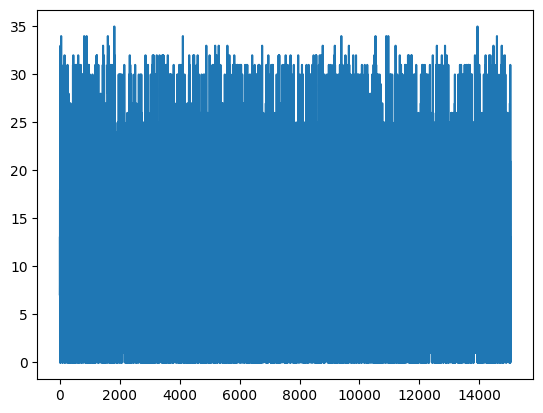

In [57]:
y_test_metrics = np.argmax(y_test, axis=1)
plt.plot(y_test_metrics)

In [148]:
print(classification_report(y_test_metrics, y_pred))

              precision    recall  f1-score   support

           0       0.06      0.02      0.03      1174
           1       0.11      0.05      0.06      1177
           2       0.05      0.37      0.09       709
           3       0.00      0.00      0.00       326
           4       0.00      0.00      0.00       132
           5       0.00      0.00      0.00        57
           6       0.20      0.00      0.01      1488
           7       0.00      0.00      0.00      1786
           8       0.07      0.34      0.12      1018
           9       0.03      0.05      0.04       397
          10       0.00      0.00      0.00       129
          11       0.00      0.00      0.00        50
          12       0.00      0.00      0.00      1099
          13       0.00      0.00      0.00      1326
          14       0.08      0.01      0.02       777
          15       0.00      0.00      0.00       301
          16       0.00      0.00      0.00        84
          17       0.00    

c:\Users\gfuen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gfuen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gfuen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,